
Papers used: 

https://web.eecs.umich.edu/~jjcorso/t/555pdf/lleintro.pdf for lle and reg

https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=37e16d10354563e6165ef1269166d3ac75b92b82 for npe

https://www.sciencedirect.com/science/article/pii/S0925231223005763#s0025 for bert

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import numpy as np
import matplotlib.pyplot as plt


In [2]:
path = "./data/News/"

emb = np.load(path + "train_embeddings.npy")
label = np.load(path + "train_labels.npy")
label_emb = np.load(path + "label_text_embeddings.npy")

In [3]:
def classifier(X_emb, y_emb, similarity_func): 
    similarity = similarity_func(X_emb, y_emb)
    preds = np.argmax(similarity, axis=1)
    return preds

def accuracy(preds, labels): 
    return np.mean([preds == labels])

def euclidian_metric(x_i, x_j): 
    return np.sqrt(np.sum(np.square(x_i - x_j), axis=-1))

In [4]:
preds = classifier(emb, label_emb, cosine_similarity)
base_accuracy = accuracy(preds, label)

print("Zero-shot accuracy, base: " + str(base_accuracy))

Zero-shot accuracy, base: 0.5421085464753587


In [5]:
rank = np.linalg.matrix_rank(emb)
print(rank)

768


In [6]:
def p1solver(data, x, neighbors, k):
    Z = data[neighbors].T
    Z = Z - np.repeat(x.T, len(neighbors), axis=0).reshape(data.shape[1], len(neighbors))
    C = Z.T @ Z

    #conditioning C
    C = C + (np.eye(C.shape[0]) * 1e-5)

    w = np.linalg.solve(C, np.ones(len(neighbors)))
    w_final = np.zeros(len(data))
    w_final[neighbors] = w
    return w_final / np.sum(w_final)

def knn(k, data, test):
    return np.argsort(np.sum(data**2, axis=1) - 2 * test.dot(data.T), axis=0)[1:k+1]

def NPEsolver(X, W, k): 
    I = np.identity(X.shape[1])
    M = (I-W).T @ (I-W) 
    T1 = np.linalg.inv(X @ X.T) 
    T2 = X @ M @ X.T
    evalues, evectors = np.linalg.eigh(T1 @ T2)
    Y = evectors[: , 1:k+1]
    return Y

def NPE(X, k, n_neighbors): 
    W = []
    for i in range((len(X))): 
        neighbors = knn(n_neighbors, X, X[i])
        W.append(p1solver(X, X[i], neighbors, k))
    W = np.asarray(W)
    return NPEsolver(X.T, W, k)

In [7]:
w = NPE(emb, 768, 100)
npe_emb = (w.T @ (emb.T)).T
npe_label = (w.T @ (label_emb.T)).T

In [8]:
preds = classifier(npe_emb, npe_label, cosine_similarity)

print("Zero-shot accuracy, base: " + str(accuracy(preds, label)))

Zero-shot accuracy, base: 0.5543177969877907


In [89]:
#get other dims 
dims = [50, 100, 200, 300, 400, 500, 600, 700, 768]
accuracies = []
weights = []

for dim in dims: 
    w = NPE(emb, dim, 100)
    npe_emb = (w.T @ (emb.T)).T
    npe_label = (w.T @ (label_emb.T)).T
    preds = classifier(npe_emb, npe_label, cosine_similarity)
    accuracies.append(accuracy(preds, label))
    weights.append(w)


(11221, 20)
(11221, 20)
(11221, 20)
(11221, 20)
(11221, 20)
(11221, 20)
(11221, 20)
(11221, 20)
(11221, 20)


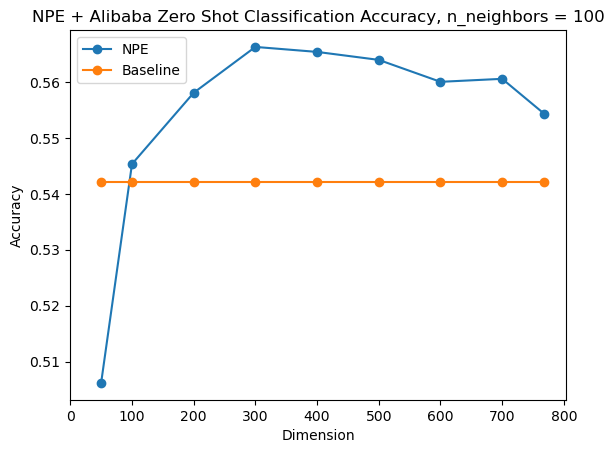

In [109]:
plt.plot(dims, accuracies, label = "NPE", marker ="o")
plt.plot(dims, [base_accuracy]*len(dims), label = "Baseline", marker = "o")
plt.xlabel("Dimension")
plt.xlim(left=0)
plt.ylabel("Accuracy")
plt.title("NPE + Alibaba Zero Shot Classification Accuracy, n_neighbors = 100")
plt.legend()
plt.show()

In [103]:
'''
PCA requires slightly different treament of labels: labels must be projected down with the embeddings, then separated out
'''

pca_accuracies = []
pca_embs = []

for dim in dims: 
    pca = PCA(n_components=dim)
    emb_PCA = pca.fit_transform(np.concatenate((emb, label_emb)))
    preds = classifier(emb_PCA[:len(emb)], emb_PCA[len(emb):], cosine_similarity)
    pca_accuracies.append(accuracy(preds, label))
    pca_embs.append(emb_pca)

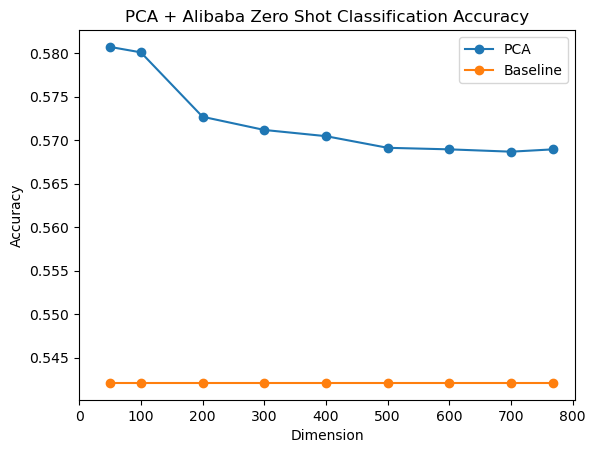

In [107]:
plt.plot(dims, pca_accuracies, label = "PCA", marker="o")
plt.plot(dims, [base_accuracy]*len(dims), label = "Baseline", marker="o")
plt.xlabel("Dimension")
plt.ylabel("Accuracy")
plt.xlim(left=0)
plt.title("PCA + Alibaba Zero Shot Classification Accuracy")
plt.legend()
plt.show()

In [9]:
iso_accuracies = []
iso_embs = []
dims = [50, 100, 200, 300, 400, 500, 600, 700, 768]

for dim in dims: 
    isomap = Isomap(n_neighbors=100, n_components=dim)
    iso_emb = isomap.fit_transform(np.concatenate((emb, label_emb)))
    preds = classifier(iso_emb[:len(emb)], iso_emb[len(emb):], cosine_similarity)
    iso_accuracies.append(accuracy(preds, label))
    iso_embs.append(iso_emb)

    print(str(dim) + " done!")

: 

In [ ]:
plt.plot(dims, iso_accuracies, label = "Isomap", marker="o")
plt.plot(dims, [base_accuracy]*len(dims), label = "Baseline", marker="o")
plt.xlabel("Dimension")
plt.ylabel("Accuracy")
plt.xlim(left=0)
plt.title("Isomap + Alibaba Zero Shot Classification Accuracy, n_neighbors=100")
plt.legend()
plt.show()